In [ ]:
import pandas as pd
import numpy as np
import torch
import torchvision
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [ ]:
dataset = MNIST(root='data/', download=True, transform=ToTensor())

In [ ]:
image, label = dataset[0]
print("image.shape:", image.shape )
plt.imshow(image.permute(1,2,0), cmap='gray')
print('Label:', label)

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

In [ ]:
batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow = 16).permute(1,2,0))
    break
    

In [ ]:
for images, labels in train_loader:
    print("images.shape", images.shape)
    inputs = images.reshape(-1,28*28)
    print('images.shape', inputs.shape)
    break

Next, let's create a nn.Linear object, which will serve as our hidden layer. We'll set the size of the output from the hidden layer to 32. This number can be increased or decreased to change the learning capacity of the model.

In [ ]:
input_size = inputs.shape[-1]
print(input_size)
hidden_size = 32

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
inputs.shape

In [ ]:
layer1_outputs = layer1(inputs)
print('Layer 1 outputs shape', layer1_outputs.shape)

In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

In [ ]:
torch.allclose(layer1_outputs, layer1_outputs_direct, 1e-3)

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print('min (layer 1 outputs:', torch.min(layer1_outputs).item())
print('min relu version:',torch.min(relu_outputs).item())

In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

In [ ]:
#Cross entropy loss function
F.cross_entropy(layer2_outputs,labels)


In [ ]:
# Expanded version of layer2(F.relu(layer1(inputs)))

outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias


In [ ]:
torch.allclose(outputs, layer2_outputs, 1e-3)


We are now ready to define our model. As discussed above, we'll create a neural network with one hidden layer. Here's what that means:

Instead of using a single nn.Linear object to transform a batch of inputs (pixel intensities) into outputs (class probabilities), we'll use two nn.Linear objects. Each of these is called a layer in the network.

The first layer (also known as the hidden layer) will transform the input matrix of shape batch_size x 784 into an intermediate output matrix of shape batch_size x hidden_size. The parameter hidden_size can be configured manually (e.g., 32 or 64).

We'll then apply a non-linear activation function to the intermediate outputs. The activation function transforms individual elements of the matrix.

The result of the activation function, which is also of size batch_size x hidden_size, is passed into the second layer (also known as the output layer). The second layer transforms it into a matrix of size batch_size x 10. We can use this output to compute the loss and adjust weights using gradient descent.

In [ ]:
class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
        
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
input_size = 28*28
hidden_size = 32
num_classes = 10


In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
for t in model.parameters():
    print(t.shape)

In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss : ', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

In [ ]:
torch.cuda.is_available()

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

In [ ]:
#The work
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

In [ ]:
history = [evaluate(model, val_loader)]
history

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)


In [ ]:
history += fit(5, 0.1, model, train_loader, val_loader)


In [61]:
history += fit(5, 0.01, model, train_loader, val_loader)


Epoch [1], val_loss: 0.0962, val_acc: 0.9710
Epoch [2], val_loss: 0.0963, val_acc: 0.9704
Epoch [3], val_loss: 0.0962, val_acc: 0.9708
Epoch [4], val_loss: 0.0962, val_acc: 0.9708


In [ ]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')

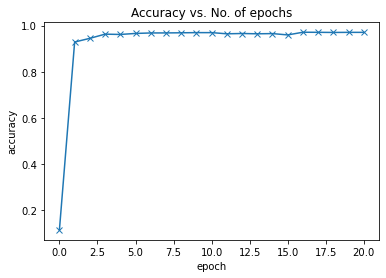

In [62]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [ ]:
test_dataset = MNIST(root = 'data/', train = False, transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _,preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


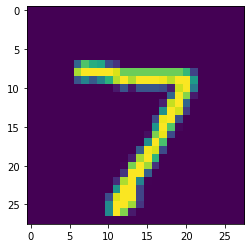

In [66]:
img, label = test_dataset[0]
plt.imshow(img[0])
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 2 , Predicted: 2


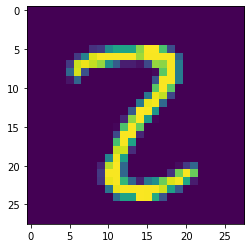

In [65]:
img, label = test_dataset[1839]
plt.imshow(img[0])
print('Label:', label, ', Predicted:', predict_image(img, model))

Label: 9 , Predicted: 9


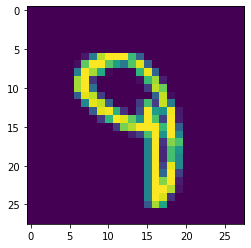

In [64]:
img, label = test_dataset[193]
plt.imshow(img[0])
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size= 256), device)
result = evaluate(model, test_loader)
result

In [ ]:
torch.save(model.state_dict(), 'mnist-feedforward.pth')